In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation

In [2]:
# load data from csv file
s_alpha = pd.read_csv('./expetimentalData/S(a)_1_pirBN_200eV.csv')
s_energy = pd.read_csv("./expetimentalData/Y(E).csv")
j_perp = pd.read_csv("./expetimentalData/j_perp.csv")

In [3]:
j_perp.head()

,jj0,z
0,0.446,-22
1,0.480,-20
2,0.551,-16
3,0.627,-12
4,0.723,-8


1. Сопоставление осей томографии и эксп. данных.
2. Представление статистических метрик.
3. Результаты эрозии.

In [2]:
# convert data to numpy array
s_alpha_x = s_alpha['x'].to_numpy()
s_alpha_y = s_alpha['y'].to_numpy()
s_energy_x = s_energy['x'].to_numpy()
s_energy_y = s_energy['y'].to_numpy()
j_perp_y = j_perp['jj0'].to_numpy()
j_perp_x = j_perp['z'].to_numpy() + max(j_perp['z']) # Offset the x axis to make it positive

# Use scipy to interpolate the data
from scipy.interpolate import interp1d
s_alpha_f = interp1d(s_alpha_x, s_alpha_y, kind='quadratic')
slope_e, intercept_e = np.polyfit(s_energy_x, s_energy_y, 1)
def s_energy_f(x):
    return slope_e * x + intercept_e
points_num = 50
s_alpha_xnew = np.linspace(min(s_alpha_x), max(s_alpha_x), num=points_num)
s_energy_xnew = np.linspace(min(s_energy_x), max(s_energy_x), num=points_num)

# Set the current density data. Later will be loaded from csv file with actual data.

np.random.seed(0)
n = min(len(s_alpha), len(s_energy))
x_start = 0
x_end = 100
j_x_coords = np.linspace(x_start, x_end, n)
j_y_coords = (j_x_coords**2 + np.random.normal(0, 1, n) * 25) * 0.01

j_y_f = interp1d(j_x_coords, j_y_coords, kind='quadratic')
j_x_coords_new = np.linspace(x_start, x_end, points_num)
j_y_coords_new = j_y_f(j_x_coords_new)

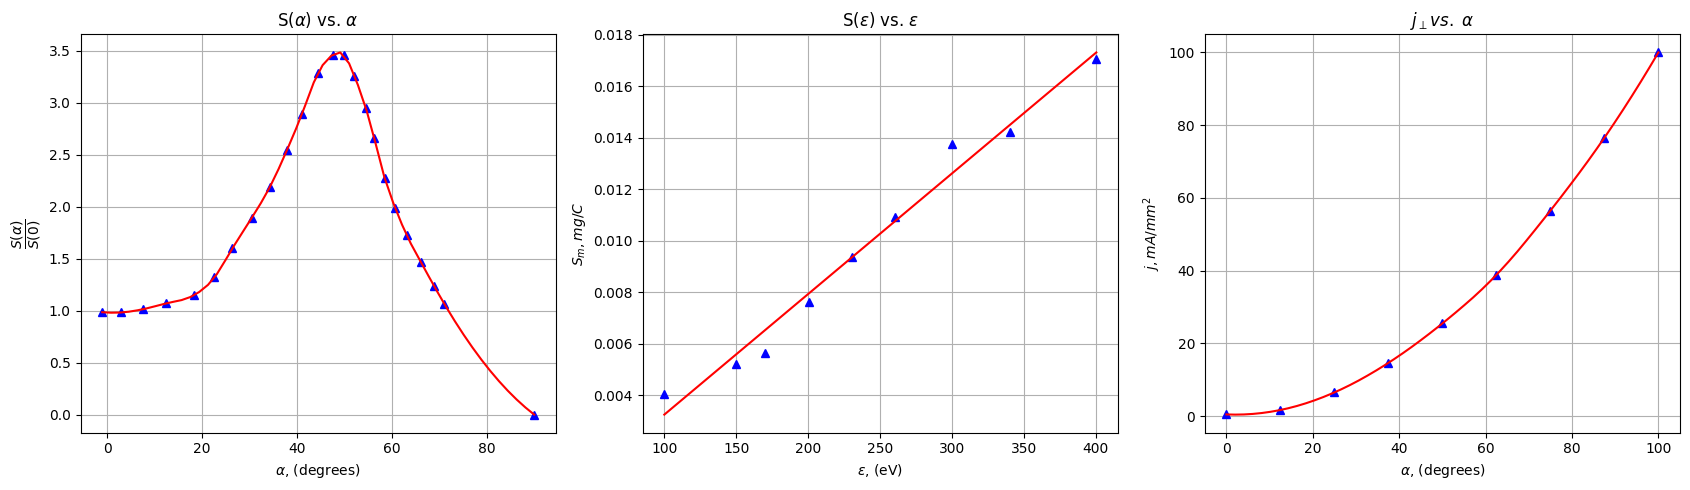

In [22]:
# Add s_alpha and s_energy to one figure. Create subplot
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(s_alpha_x, s_alpha_y, marker='^', color='blue', linestyle='None', label=r'S($\alpha$)')
axs[0].plot(s_alpha_xnew, s_alpha_f(s_alpha_xnew), color='red', linestyle='-', label=r'S($\alpha$) RMS')
axs[0].set_title(r'S($\alpha$) vs. $\alpha$')
axs[0].set_xlabel(r'$\alpha$, (degrees)')
axs[0].set_ylabel(r'$\dfrac{S(\alpha)}{S(0)}$')
axs[0].grid(True)

axs[1].plot(s_energy_x, s_energy_y, marker='^', color='blue', linestyle='None', label=r'S($\alpha$)')
axs[1].plot(s_energy_xnew, s_energy_f(s_energy_xnew), color='red', linestyle='-', label=r'S($\alpha$) RMS')
axs[1].set_title(r'S($\epsilon$) vs. $\epsilon$')
axs[1].set_xlabel(r'$\epsilon$, (eV)')
axs[1].set_ylabel(r'$S_m, mg/C$')
axs[1].grid(True)

axs[2].plot(j_x_coords, j_y_coords, marker='^', color='blue', linestyle='None', label=r'Current density')
axs[2].plot(j_x_coords_new, j_y_coords_new, color='red', linestyle='-', label=r'Current density RMS')
axs[2].set_title(r'$j_{\perp} vs.\;\alpha$')
axs[2].set_xlabel(r'$\alpha$, (degrees)')
axs[2].set_ylabel(r'$j, mA/mm^2$')
axs[2].grid(True)
plt.tight_layout()
#plt.savefig("./illustrations/exp_data.png", dpi=300)

In [19]:
def alpha_f(x0, y0, x1, y1):
    """
    Function calculates the angle between vector and x axis.
    First vector is defined by x0, y0 and x1, y1.
    Second "vector" is always x axis.
    """
    dx = np.abs(x1 - x0)
    dy = np.abs(y1 - y0)
    dx_is_zero = dx == 0
    alpha = np.where(dx_is_zero, np.pi/2, np.arctan(dy / dx))
    return alpha
    
# def gamma_f(x, y):
#     """
#     Function calculates the angle between current two vectors.
#     First vector is defined by x[i], y[i] and x-axis.
#     Second vector is defined by x[i-1], y[i-1] and x[i], y[i].
#     """
#     gamma = np.zeros(len(x))
#     for i in range(1, len(x)):
#         dx = np.abs(x[i] - x[i-1])
#         dy = np.abs(y[i] - y[i-1])
#         dx_is_zero = dx == 0
#         gamma[i] = np.where(dx_is_zero, 90, np.arctan(dy / dx) * 180 / np.pi)
#     return gamma

def gamma_f(x1, y1, x2, y2):
    """
    Function calculates the angle between current two vectors.
    First vector is defined by x1, y1 and x-axis.
    Second vector is defined by x2, y2 and x1, y1.
    """
    dx = np.abs(x1 - x2)
    dy = np.abs(y1 - y2)
    dx_is_zero = dx == 0
    gamma = np.where(dx_is_zero, np.pi/2, np.arctan(dy / dx))
    return gamma


In [20]:
# Parameters
tau = 10**3  # seconds
dt = 1  # seconds
    
# Define ellipse parameters
center_x = 0.25
center_y = 1.0
semimajor_axis = 0.05
semiminor_axis = 0.3

num_points = 10**2
ion_sources = 10**0

# Generating random source positions within the specified ellipse
theta = np.random.uniform(0, 2 * np.pi, size=ion_sources)
r = np.random.uniform(0, 1, size=ion_sources)

if ion_sources == 1:
    ion_src_x = center_x + semimajor_axis * r * np.cos(np.random.choice(theta))
    ion_src_y = center_y + semiminor_axis * r * np.sin(np.random.choice(theta))
else:
    ion_src_x = center_x + semimajor_axis * r * np.cos(theta)
    ion_src_y = center_y + semiminor_axis * r * np.sin(theta)

sim_start_x = 0
sim_end_x = 1
profile_x = np.linspace(sim_start_x, sim_end_x, num_points)
profile_y = np.zeros(len(profile_x))

# Creating an array to store the erosion profile at different time steps
num_steps = int(tau / dt)
profile_time = np.zeros((num_steps, len(profile_x)))

alpha_array = np.zeros(len(profile_x))
gamma_array = np.zeros(len(profile_x))

# Precompute constants
ion_energy = 200
s_energy = s_energy_f(ion_energy)

min_profile_y = np.inf  # Initialize a variable to keep track of the minimum profile_y

for step in range(num_steps):
    for i, x in enumerate(profile_x):
        # Calculate the angle between the current point and all ion sources
        alpha = alpha_f(ion_src_x, ion_src_y, x, profile_y[i])
        alpha_array[i] = np.degrees(alpha)

        # Calculate the angle between the current point and the previous point
        gamma = gamma_f(ion_src_x, ion_src_y, x, profile_y[i])
        gamma_array[i] = gamma

        # Calculate the erosion rate at the current point
        erosion = np.abs(s_alpha_f(alpha) * s_energy * j_y_f(alpha) * np.cos(gamma) * dt)

        # Check for shadowing
        if profile_y[i] > min_profile_y:
            min_profile_y = profile_y[i]
            # Calculate the angle between the current point and all ion sources
            alpha = alpha_f(ion_src_x, ion_src_y, x, profile_y[i])
            alpha_array[i] = alpha

            # Calculate the angle between the current point and the previous point
            gamma = gamma_f(ion_src_x, ion_src_y, x, profile_y[i])
            gamma_array[i] = gamma

            # Calculate the erosion rate at the current point
            erosion = np.abs(s_alpha_f(alpha) * s_energy * j_y_f(x) * np.cos(gamma) * dt)
        else:
            # Calculate the erosion rate at the minimum point if shadowed
            i_min = np.argmin(min_profile_y)
            # Calculate the angle between the current point and all ion sources
            alpha = alpha_f(ion_src_x, ion_src_y, x, profile_y[i_min])
            alpha_array[i_min] = alpha

            # Calculate the angle between the current point and the previous point
            gamma = gamma_f(ion_src_x, ion_src_y, x, profile_y[i_min])
            gamma_array[i_min] = gamma

            # Calculate the erosion rate at the current point
            erosion = np.abs(s_alpha_f(alpha) * s_energy * j_y_f(x) * np.cos(gamma) * dt)
            erosion = np.abs(s_alpha_f(alpha) * s_energy * j_y_f(x) * np.cos(gamma) * dt)

        if x < ion_src_x:
            erosion = 0
        profile_y[i] -= erosion
        profile_time[step, i] = profile_y[i]

print(ion_src_x.shape, ion_src_y.shape, profile_x.shape, profile_y.shape)

C:\TMP\ipykernel_13984\522818998.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_array[i] = np.degrees(alpha)
C:\TMP\ipykernel_13984\522818998.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma_array[i] = gamma
C:\TMP\ipykernel_13984\522818998.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha_array[i_min] = alpha
C:\TMP\ipykernel_13984\522818998.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, an

(1,) (1,) (100,) (100,)


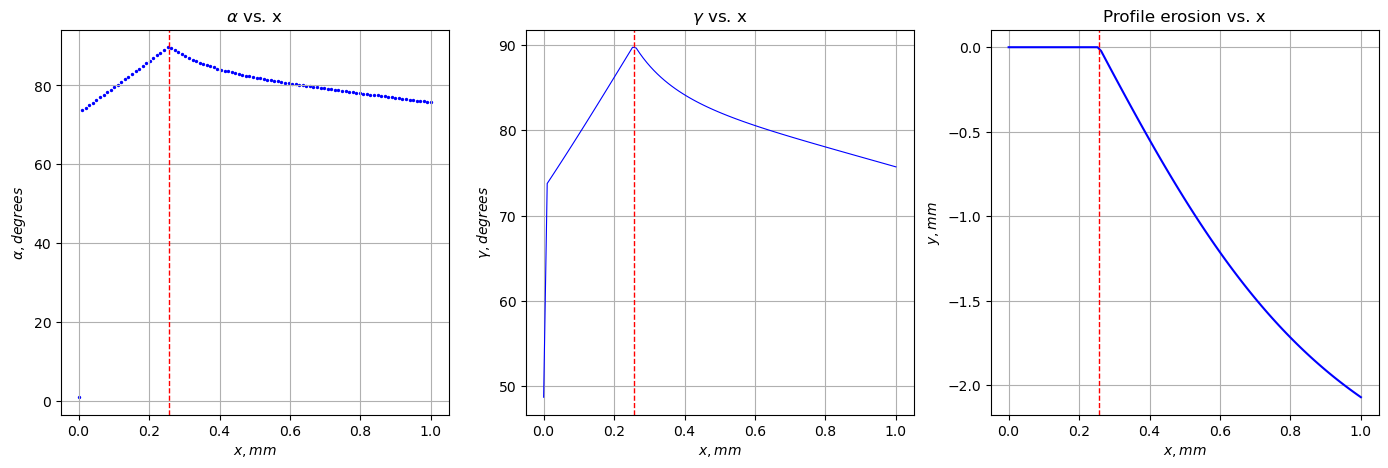

In [7]:
# Plot alpha vs. x
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].scatter(profile_x, alpha_array, color='blue', linestyle='-', label=r'$\alpha$', s=2)
axs[0].axvline(ion_src_x, color='red', linestyle='--', linewidth=1)
axs[0].set_title(r'$\alpha$ vs. x')
axs[0].set_xlabel(r'$x, mm$')
axs[0].set_ylabel(r'$\alpha, degrees$')
axs[0].grid(True)

axs[1].plot(profile_x, np.degrees(gamma_array), color='blue', linestyle='-', label=r'$\gamma$', linewidth=0.8)
axs[1].axvline(ion_src_x, color='red', linestyle='--', linewidth=1)
axs[1].set_title(r'$\gamma$ vs. x')
axs[1].set_xlabel(r'$x, mm$')
axs[1].set_ylabel(r'$\gamma, degrees$')
axs[1].grid(True)

axs[2].plot(profile_x, profile_time[-1, :], color='blue', linestyle='-', label=r'$y$')
axs[2].axvline(ion_src_x, color='red', linestyle='--', linewidth=1)
axs[2].set_title(r'Profile erosion vs. x')
axs[2].set_xlabel(r'$x, mm$')
axs[2].set_ylabel(r'$y, mm$')
axs[2].grid(True)

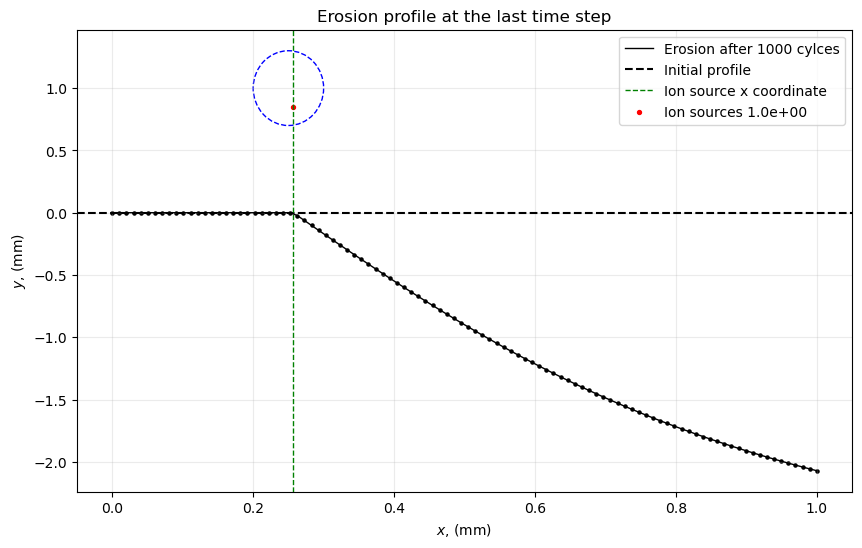

In [8]:
# Plot erosion profile at the last time step
plt.figure(figsize=(10, 6))
plt.plot(profile_x, profile_time[-1, :], color='black', linestyle='-', label=r'Erosion after {} cylces'.format(tau), linewidth=1, alpha=1)
plt.scatter(profile_x, profile_time[-1, :], color='black', s=5, alpha=1)
# Add initial profile
plt.axhline(y=0, color='black', linestyle='--', label='Initial profile')
plt.axvline(ion_src_x, color='green', linestyle='--', label='Ion source x coordinate', linewidth=1)
# Plot the ellipse
plt.scatter(ion_src_x, ion_src_y, marker='o', color='red', linestyle='None', label=f'Ion sources {ion_sources:.1e}', s=8, alpha=1)
plt.title(r'Erosion profile at the last time step')
plt.xlabel(r'$x$, (mm)')
plt.ylabel(r'$y$, (mm)')
plt.legend()
# Define ellipse parameters for the boundaries
boundary_ellipse = Ellipse(
    (center_x, center_y),
    width=2 * semimajor_axis,
    height=2 * semiminor_axis,
    edgecolor='blue',
    facecolor='none',
    linewidth=1,
    linestyle='--',
    alpha=1,
)
plt.gca().add_patch(boundary_ellipse)
plt.grid(True, alpha=0.25)
plt.show()

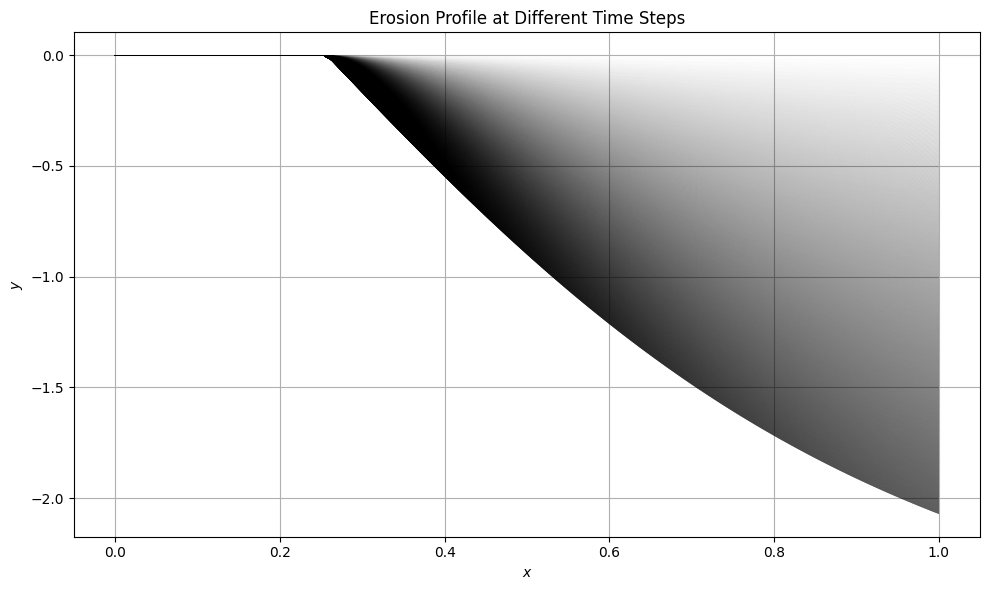

In [11]:
plt.figure(figsize=(10, 6))
for step in range(num_steps):
    trsp = step / num_steps  # Calculate alpha for transparency
    plt.plot(profile_x, profile_time[step, :], label=f'Time Step {step}', alpha=trsp, color='black', linewidth=0.25)
    #plt.scatter(profile_x, profile_time[step, :], alpha=alpha, color='black', s=5)
plt.title('Erosion Profile at Different Time Steps')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.tight_layout()
plt.show()